# Brain Tumor Detection with CNN

#### 組員：羅際東、黃品慈、Calvin Tsai、何豐吉、Jean、Hao
### Table of Contents


1. 專案簡介及目標
  1. 資料集說明
  2. 何謂腦腫瘤
2. 建立環境
3. 資料載入及資料預處理
4. CNN 模型
  1. vgg16模型
  2. 一般自定義模型
  3. 效能評估
5. 總結
6. 資料來源



# 1.專案簡介及目標
這個專案的主要目的是建立一個卷積神經網絡(CNN)模型,根據MRI掃描判斷受測者是否患有腫瘤。本專案使用了CNN和DNN對這個二元問題進行建模與訓練。最後將以**準確度**作為評估模型效能的指標

## 1.1 資料集說明
本專案的影像使用的是Kaggle資料集[Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?select=yes)。總共分兩類:


*   `NO` - 沒有腦腫瘤
*   `Yes` - 有腦腫瘤

註: 該資料集作者並未說明腦腫瘤影像的出處

## 1.2 何謂腦腫瘤
當大腦內形成異常細胞時，就會發生腦腫瘤。腫瘤主要有兩種：惡性腫瘤和良性（非癌性）腫瘤。這些腫瘤可以進一步分為原發性腫瘤（起始於腦內）和繼發性腫瘤（最常見的是從位於腦外的腫瘤擴散，稱為腦轉移瘤）。所有類型的腦腫瘤都可能產生不同的症狀，這取決於腫瘤的大小和所涉及的大腦部分。如果有症狀，可能包括頭痛、癲癇發作、視力問題、嘔吐和精神變化。其他症狀可能包括行走困難、說話困難、有感覺或失去知覺。

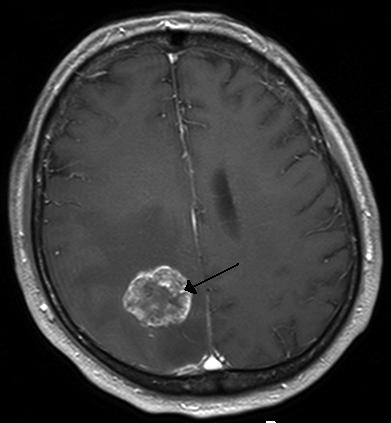

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# 2.建立環境


In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [2]:
import cv2
import imutils
from google.colab.patches import cv2_imshow
import os
# tqdm 顯示進度條
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as img
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix, confusion_matrix,precision_score, recall_score, f1_score
from keras.applications.vgg16 import VGG16

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!apt-get install tree
clear_output()
# 展示目錄結構
%cd /content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset
!tree -d

/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset
.
├── crop
│   ├── no
│   └── yes
├── model_output
│   └── conv
├── test
│   ├── no
│   └── yes
├── train
│   ├── no
│   └── yes
└── valid
    ├── no
    └── yes

14 directories


# 3.資料載入及資料預處理

In [5]:
(img_height, img_width) = 224,224
output_dir = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/model_output/conv'
data_dir = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset"

# dir_path: "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/test/""
def load_data(dir_path):
  # 撈出yes/no資料夾
  folders = glob(dir_path+"/*")
  X = []
  y = []
  i = 0   # no: 0, yes: 1
  image_to_show = dict()
  image_to_show[0] = []
  image_to_show[1] = []
  # 使用sorted，確保讀入順序都是先no再yes
  for fold in sorted(folders):
    print(fold)
    # tqdm 顯示載入照片進度條
    for dir in tqdm(os.listdir(fold)):
      if i == 0:
        image_to_show[0].append(fold+"/"+dir)
      else:
        image_to_show[1].append(fold+"/"+dir)
      img = cv2.imread(fold+"/"+dir,cv2.IMREAD_GRAYSCALE)
      X.append(img)
      y.append(i)
    i += 1
  X = np.array(X)
  y = np.array(y)
  print(f"{len(X)} 張圖片從路徑 {dir_path} 載入\n")
  return X,y,image_to_show

TRAIN_DIR = data_dir + '/train'
TEST_DIR = data_dir + '/test'
VAL_DIR = data_dir + '/valid'

X_train, y_train, image_to_show = load_data(TRAIN_DIR)
X_test, y_test, _ = load_data(TEST_DIR)
X_val, y_val, _ = load_data(VAL_DIR)

/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/train/no


100%|██████████| 64/64 [00:30<00:00,  2.08it/s]


/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/train/yes


100%|██████████| 102/102 [00:02<00:00, 40.45it/s]


166 張圖片從路徑 /content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/train 載入

/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/test/no


100%|██████████| 28/28 [00:15<00:00,  1.79it/s]


/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/test/yes


100%|██████████| 42/42 [00:21<00:00,  1.98it/s]


70 張圖片從路徑 /content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/test 載入

/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/valid/no


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/valid/yes


100%|██████████| 11/11 [00:05<00:00,  1.95it/s]

17 張圖片從路徑 /content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/valid 載入


In [6]:
# 計算各三個資料集的no/yes個數
y = dict()
y["no"] = []
y["yes"] = []
for label in (y_train,y_test,y_val):
  y["no"].append(np.sum(label == 0))
  y["yes"].append(np.sum(label == 1))

print(y)
df = pd.DataFrame(y,
                  index=["train","test","valid"])
df

{'no': [64, 28, 6], 'yes': [102, 42, 11]}


no  yes
train  64  102
test   28   42
valid   6   11

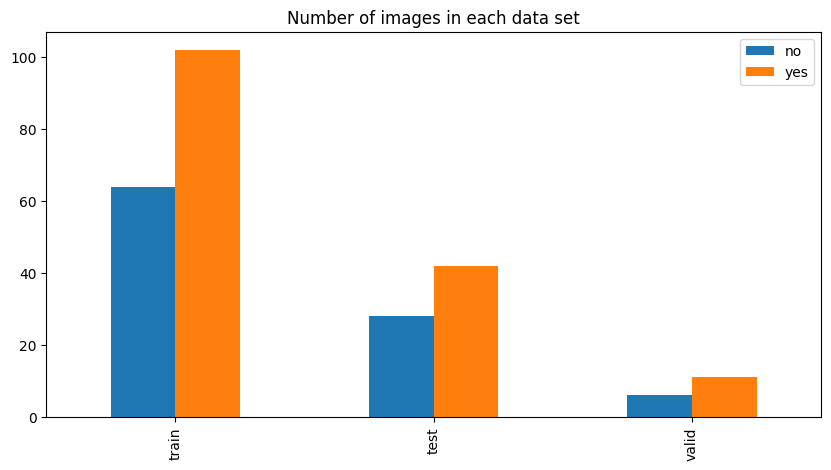

In [7]:
g1 = df.plot(kind='bar',title='Number of images in each data set',figsize=[10,5])

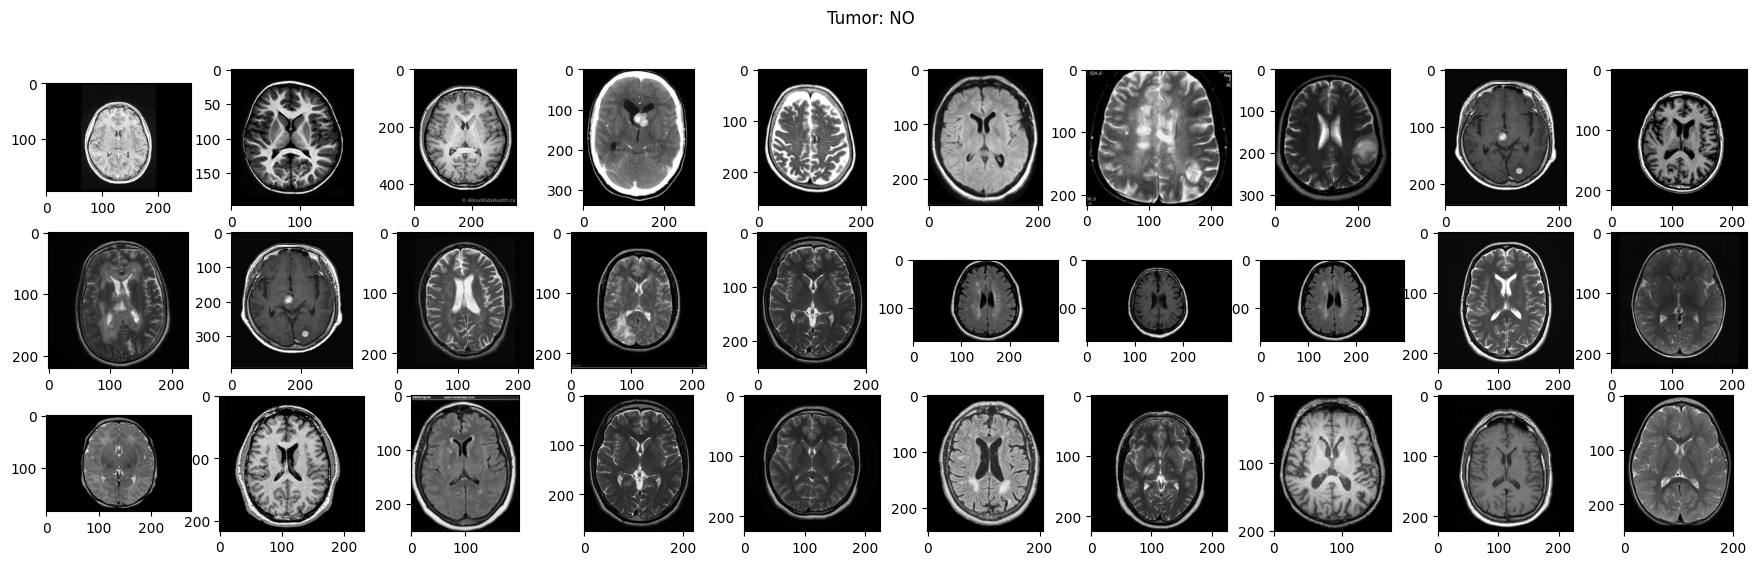

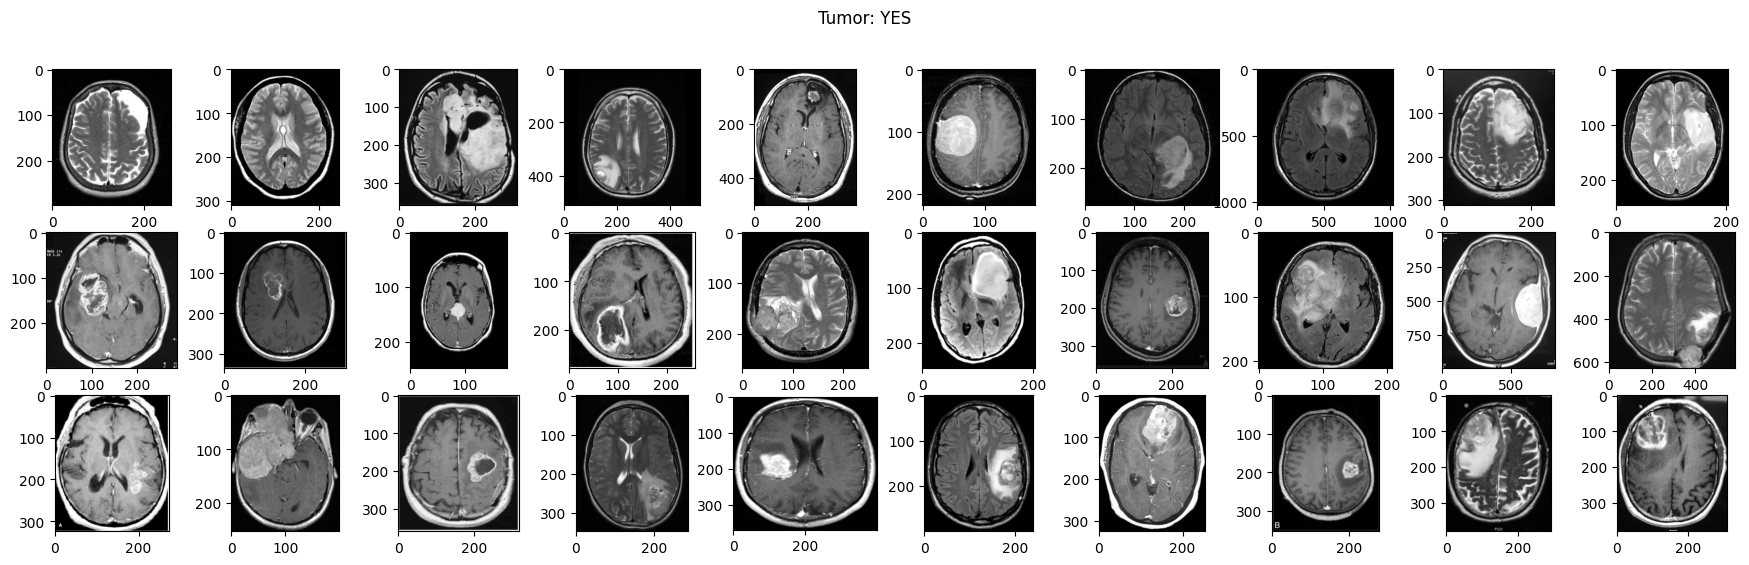

In [8]:
def plot_images(X,y,images,n=30):
  for key in images.keys():
    imgs = X[np.argwhere(y == key)][:n]
    col = 10
    row = int(n/col)
    plt.figure(figsize=(22,6))
    i = 1
    for img in imgs:
      plt.subplot(row, col, i)
      plt.imshow(img[0],cmap="gray")
      i += 1
    if key == 0:
      plt.suptitle('Tumor: NO')
    else:
      plt.suptitle('Tumor: YES')
    plt.show()

plot_images(X_train,y_train,image_to_show)

腦腫瘤資料集的影像具有不同的寬度和高度以及不同大小的“黑角”。 由於 VGG-16 輸入層的影像大小為 (224,224)，因此某些寬影像在調整大小後可能看起來很奇怪。

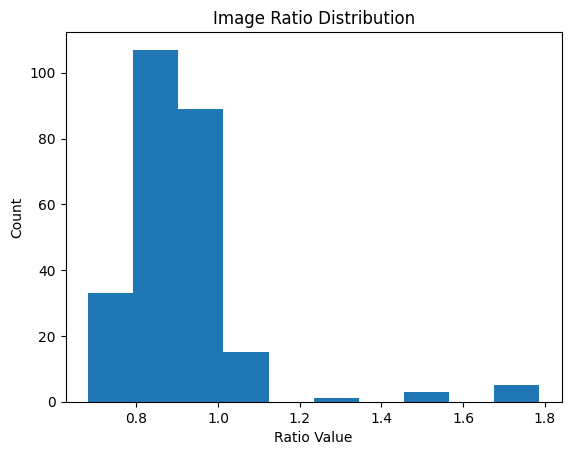

In [9]:
# 寬img.shape[1]:高img.shape[0] 比直方圖 => 圖像具有不同的寬度和高度
height_width_ratio = []
for set in (X_train, X_test, X_val):
    for img in set:
      height_width_ratio.append(img.shape[1]/img.shape[0])

plt.hist(height_width_ratio)
plt.title('Image Ratio Distribution')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

第一步：從影像中裁剪出大腦。使用 cv2.findContours

In [10]:
def crop_img(data_set, add_pixels=0):
  new_data_set = []
  for img in data_set:
    if len(img.shape) == 3 and img.shape[2] == 3:
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
      gray = img
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # threshold: 二值化黑白影像
    # erode: 移除影像中的小白雜點,雜訊
    # dilate: 將剛剛erode的影像膨脹回來。
    thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # 找到沿輪廓的最極值點
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # 額外擴增 pixels，若無則預設 0
    ADD_PIXELS = add_pixels
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    new_data_set.append(new_img)

  return np.array(new_data_set)


### 演示：影像輪廓抓取 與 裁切影像

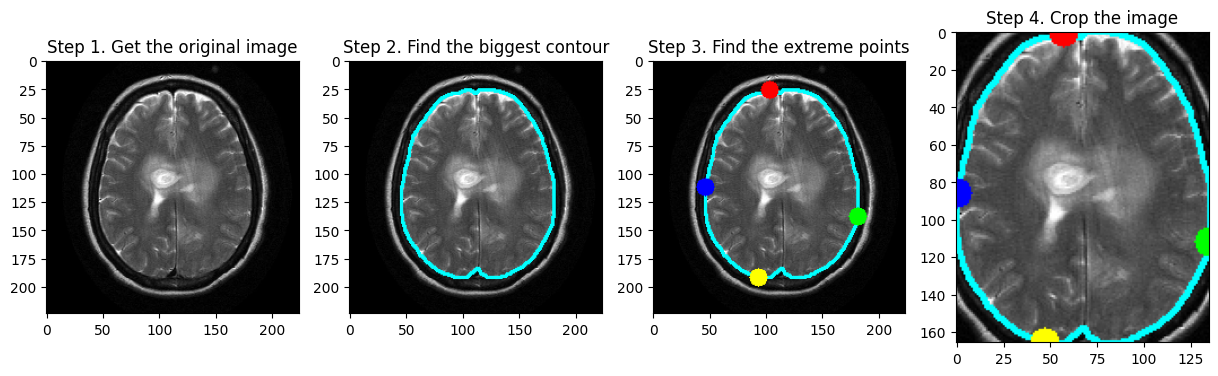

In [11]:
plt.figure(figsize=(15,6))
plt.subplot(141)

img = cv2.imread(data_dir+"/train/yes/Y9.jpg")
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
plt.imshow(img)
plt.title('Step 1. Get the original image')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])
# Contours
img_cnt = cv2.drawContours(img, [c], -1, (0, 255, 255), 2)
plt.subplot(142)
plt.imshow(img_cnt)
plt.title('Step 2. Find the biggest contour')
# extreme points
img_extreme = cv2.circle(img, extLeft, 8, (0, 0, 255), -1)
img_extreme = cv2.circle(img, extRight, 8, (0, 255, 0), -1)
img_extreme = cv2.circle(img, extTop, 8, (255, 0, 0), -1)
img_extreme = cv2.circle(img, extBot, 8, (255, 255, 0), -1)
plt.subplot(143)
plt.imshow(img_extreme)
plt.title('Step 3. Find the extreme points')

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
plt.subplot(144)
plt.imshow(new_img)
plt.title('Step 4. Crop the image')
plt.show()

將每個資料集都進行裁切處理

In [12]:
X_train_crop = crop_img(data_set=X_train)
X_test_crop = crop_img(data_set=X_test)
X_val_crop = crop_img(data_set=X_val)

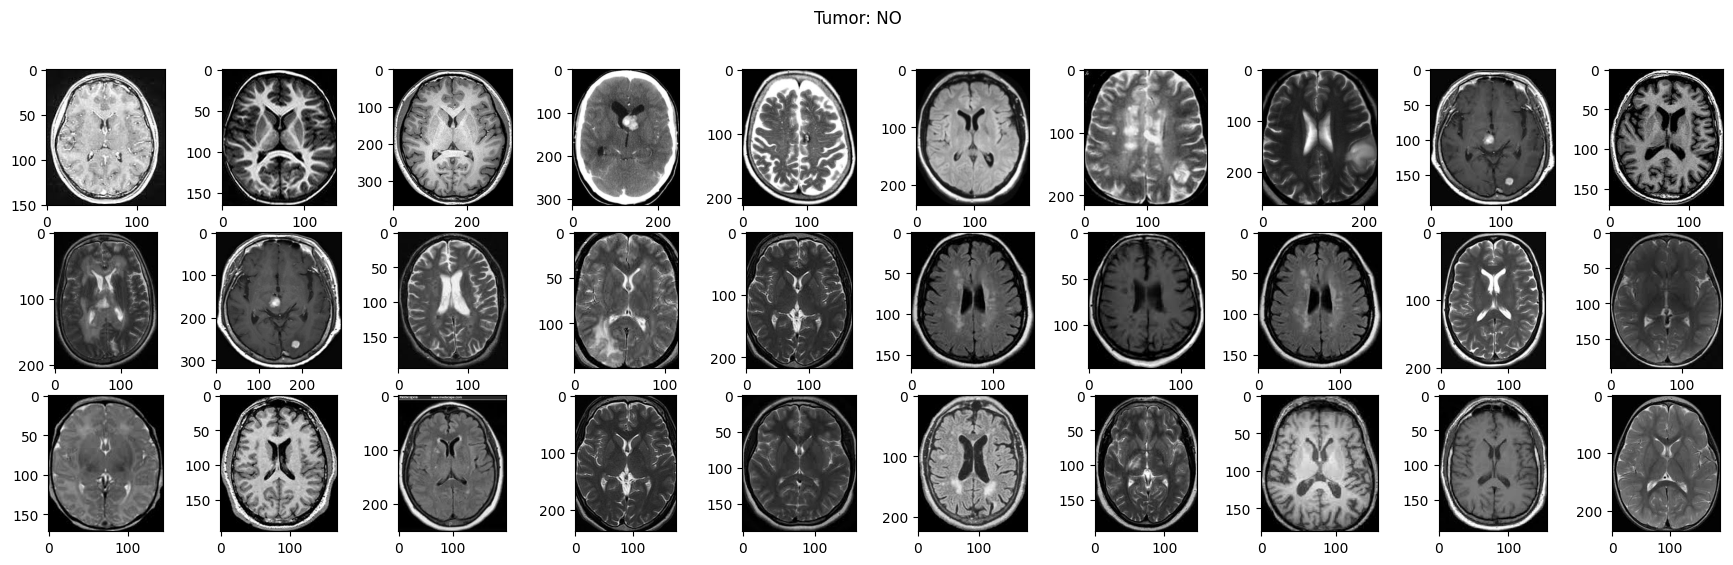

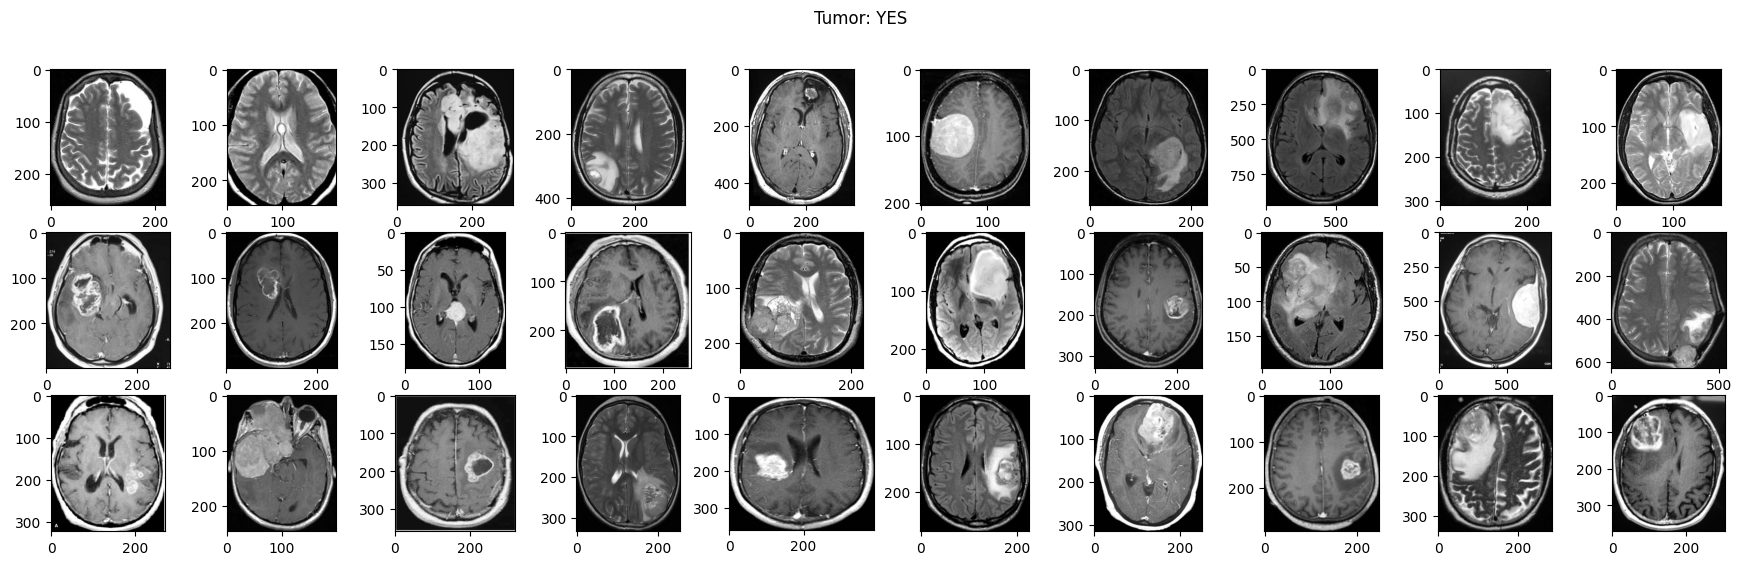

In [13]:
plot_images(X_train_crop,y_train,image_to_show)

儲存新的裁切影像

In [14]:
crop_dir = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/crop"
def save_new_images(x_set, y_set, key):
    i = 0
    for (img, label) in zip(x_set, y_set):
        if label == 0:
            cv2.imwrite(crop_dir +'/no/'+key+str(i)+'.jpg', img)
        else:
            cv2.imwrite(crop_dir +'/yes/'+key+str(i)+'.jpg', img)
        i += 1

In [15]:
save_new_images(X_train_crop, y_train, 'train')
save_new_images(X_test_crop, y_test, 'test')

使用ImageDataGenerator做資料增強

In [16]:
datagen = ImageDataGenerator(rescale=1./255,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_set = datagen.flow_from_directory(crop_dir,
                                        target_size=(img_height, img_width),
                                        batch_size=10,
                                        class_mode="categorical",
                                        subset="training",
                                        color_mode="grayscale",
                                        shuffle=True)
test_set = datagen.flow_from_directory(crop_dir,
                                      target_size=(img_height,img_width),
                                      batch_size=10,
                                      subset="validation",
                                      class_mode='categorical',
                                      color_mode="grayscale")

Found 190 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [18]:
valid_set = valid_datagen.flow_from_directory(data_dir+'/valid',
                                              target_size=(img_height, img_width),
                                              batch_size=10,
                                              class_mode="categorical",
                                              color_mode="grayscale")
y_test = valid_set.labels
print(len(y_test))

Found 17 images belonging to 2 classes.
17


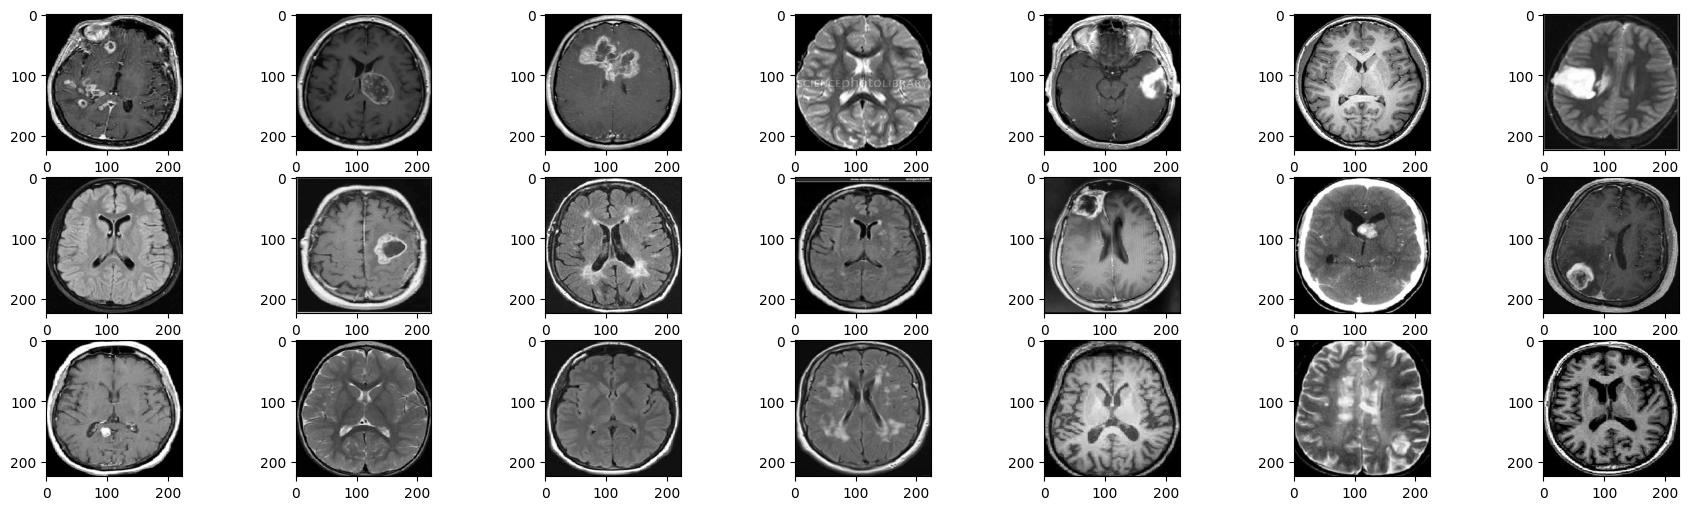

In [19]:
# 畫train_set圖
num_images_to_plot = 21

plt.figure(figsize=(22,6))
row = 3
col = 7

for i in range(1,num_images_to_plot+1):
    batch = train_set.next()
    images, labels = batch
    plt.subplot(row, col, i)
    # Plot the first image from the batch
    plt.imshow(images[0][:, :, 0], cmap='gray')
plt.show()

# 4.CNN 模型

## 4.1 vgg16模型

In [ ]:
# 使用vgg16
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
history = model.fit(train_set,validation_data=test_set,epochs=50,batch_size=32,verbose=2,callbacks=[])

## 4.2 一般自定義模型

In [20]:
# 設定模型
model = Sequential()
model.add(Conv2D(256,(3,3),activation='relu',padding='same',input_shape=(224,224,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation="relu",padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation="relu",padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation="relu",padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(200,activation="relu"))
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="softmax"))
model.summary()
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
#LR_function=ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,mode = 'auto',factor=0.1,min_lr=0.00001)
history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=50,
                    batch_size=64,
                    verbose=2,callbacks=[modelcheckpoint])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 256)     2560      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 256)     1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 256)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     295040    
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 128)     512       
 chNormalization)                                                
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 - 15s - loss: 4.5610 - accuracy: 0.5368 - val_loss: 0.7817 - val_accuracy: 0.6087 - 15s/epoch - 778ms/step
Epoch 2/50
19/19 - 2s - loss: 2.2391 - accuracy: 0.5579 - val_loss: 1.3784 - val_accuracy: 0.6087 - 2s/epoch - 93ms/step
Epoch 3/50
19/19 - 2s - loss: 1.1503 - accuracy: 0.6579 - val_loss: 2.9043 - val_accuracy: 0.6087 - 2s/epoch - 94ms/step
Epoch 4/50
19/19 - 2s - loss: 0.8531 - accuracy: 0.6105 - val_loss: 3.8663 - val_accuracy: 0.6087 - 2s/epoch - 94ms/step
Epoch 5/50
19/19 - 2s - loss: 0.6451 - accuracy: 0.7000 - val_loss: 4.0527 - val_accuracy: 0.6087 - 2s/epoch - 95ms/step
Epoch 6/50
19/19 - 2s - loss: 0.6316 - accuracy: 0.7000 - val_loss: 4.4054 - val_accuracy: 0.6087 - 2s/epoch - 97ms/step
Epoch 7/50
19/19 - 2s - loss: 0.6254 - accuracy: 0.7316 - val_loss: 3.7944 - val_accuracy: 0.6087 - 2s/epoch - 97ms/step
Epoch 8/50
19/19 - 2s - loss: 0.6361 - accuracy: 0.6526 - val_loss: 4.4678 - val_accuracy: 0.6087 - 2s/epoch - 96ms/step
Epoch 9/50
19/19 - 2s - loss: 0.5728 - a

## 4.3 效能評估

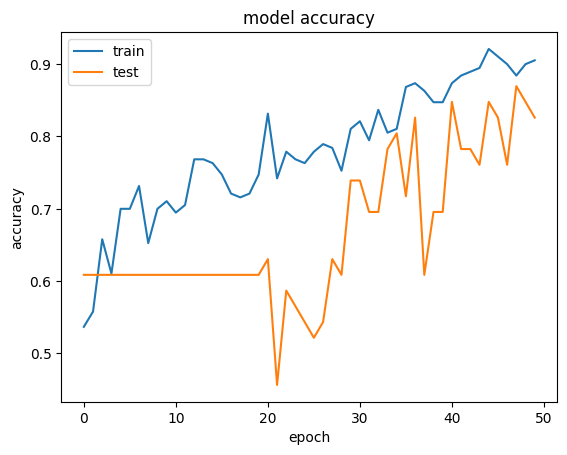

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

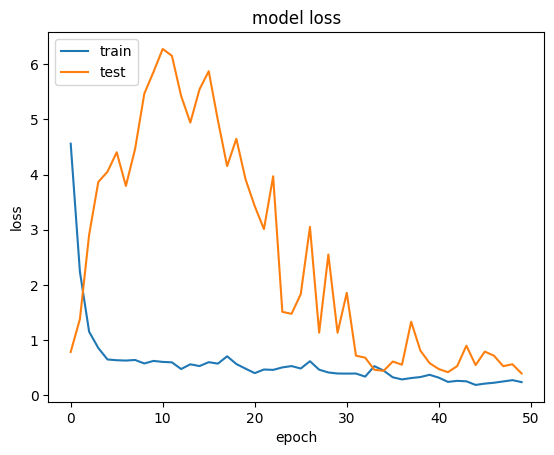

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
highest = 0
high_index = 0
for i,ac in enumerate(history.history['val_accuracy']):
  if ac > highest:
    highest = ac
    high_index = i

print("val_accuracy最高為:",highest)
print("第{}個權重檔".format(high_index+1))

val_accuracy最高為: 0.8695651888847351
第48個權重檔


In [27]:
#視以上執行結果指定較佳的權重
model.load_weights(output_dir+"/weights.{}.hdf5".format(high_index+1))

In [33]:
result = model.predict(valid_set)
y_pred = np.argmax(result, axis=1)
#print(len(y_pred))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))

2/2 [==============================] - 0s 16ms/step
Accuracy: 0.71


混淆矩陣

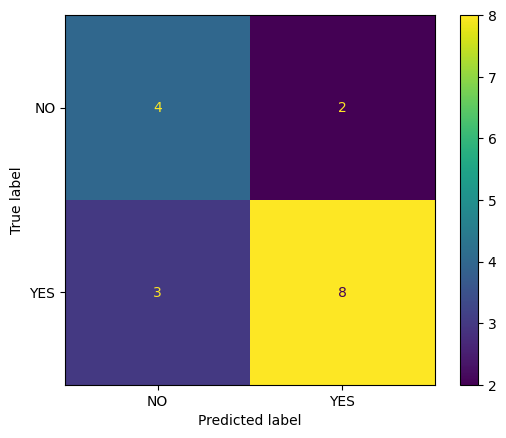

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline
confusion_mat=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["NO","YES"])
disp.plot()
plt.show()

實際演示單一圖片預測

In [35]:
classes = ["Brain Tumor: NO","Brain Tumor: YES"]

In [36]:
from keras.preprocessing import image

def predict_image(img):
    plt.figure(figsize=(40,8))
    x=image.img_to_array(img)
    x=x/255
    plt.imshow(img,cmap="gray")
    x=np.expand_dims(x,axis=0)
    print(classes[np.argmax(model.predict(x))])

1/1 [==============================] - 0s 18ms/step
Brain Tumor: YES


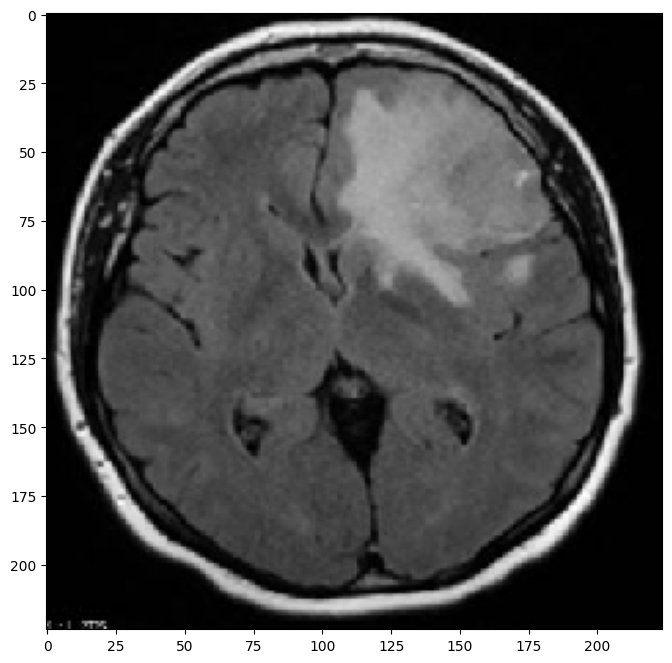

In [41]:
valid_dir = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/valid"
im=image.load_img(valid_dir+'/yes/Y195.JPG',target_size=(224,224),color_mode="grayscale")
predict_image(im)

1/1 [==============================] - 0s 27ms/step
Brain Tumor: NO


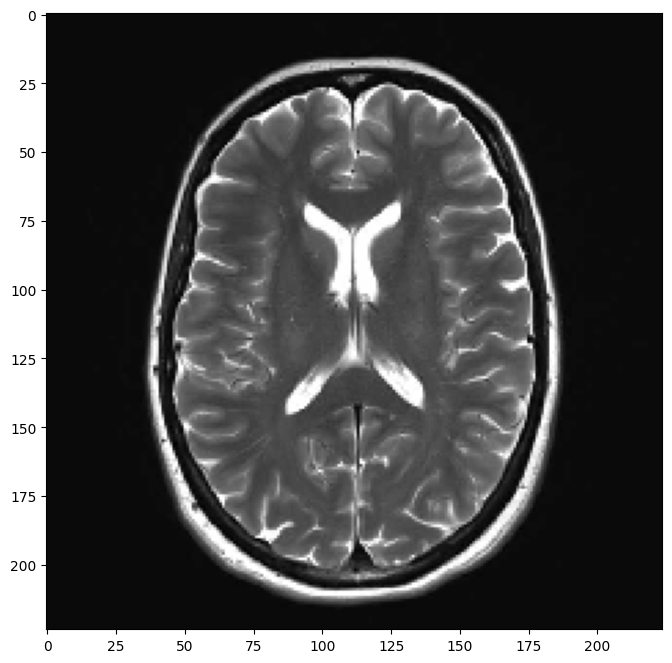

In [42]:
im2=image.load_img(valid_dir+'/no/No11.jpg',target_size=(224,224),color_mode="grayscale")
predict_image(im2)

# 5.總結

這個專案結合了CNN模型分類問題（用於預測被測主體是否患有腦腫瘤）和計算機視覺問題（用於自動化從MRI掃描中裁剪腦部的過程）。最終的準確度遠高於50%的基準線（隨機猜測）。然而，這個準確度可以透過增加訓練圖片的數量或通過調整模型超參數來進一步提高。

# 6.資料來源
### kaggle資料集 : Brain MRI Images for Brain Tumor Detection
### 資料集解釋 : 總共253個檔案，其中no有98個檔案，Yes有155個檔案
### [資料集鏈接][1]
### [參考模型1][2]
### [參考模型2][3]

[1]:<https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?select=yes> "Brain MRI資料鏈接"
[2]: <https://www.kaggle.com/code/aissaasasd/brain-tumor-detector-92> "參考模型1"
[3]: <https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16> "參考模型2"